<h1 style = "color: #FF9900"><center>HW 4: Random Graph Models</center></h1>
<h3><center> Kunmao Li (A53276560) </center></h3>

***

<h2 style = "color: #FF9900">Task 1: HOT Networks</h2>

In this task you are given a core network inspired by an actual infrastructure and you are supposed to __connect random nodes to the nodes of this core network according to a power law__. Then you are supposed to calculate a performance measure for this network. 

Then, you are supposed to __create a preferential attachment random graph based on the <font style = "color: #FF9900">Barabasi-Albert model</font> with the same number of nodes and compare the perfomance measure of this network to the first network__. 

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import warnings
import sys
from powerlaw import Power_Law
import math 
from math import log
from collections import defaultdict, Counter
warnings.filterwarnings('ignore')

### Step 1: Create the following graph in NetworkX.
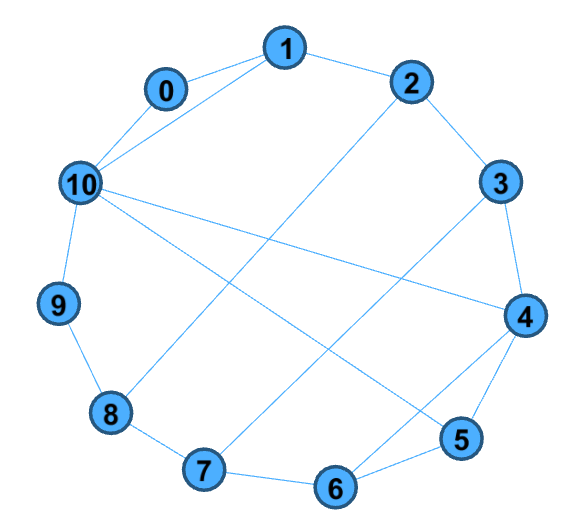

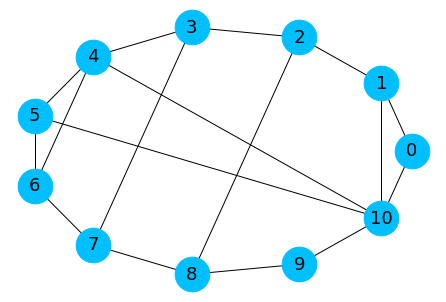

In [2]:
# init
g = nx.Graph()
# create edges
edges = [(i, i+1) if i < 10 else (i, 0) for i in range(11)]
edges.extend([(1, 10), (2, 8), (3, 7), (4, 6), (4, 10), (5, 10)])
# add edges in graph
g.add_edges_from(edges)
# visualize
nx.draw_circular(g, with_labels = True, node_color = "deepskyblue", node_size = 1200, font_size = 18)

### Step 2: Connect new nodes
To each node of the above core network, connect __a random number of new nodes__ according to a __power law distribution__ with $\alpha = 3$.

In [3]:
distribution = Power_Law(xmin = 3, parameters = [3], discrete = True)
data = distribution.generate_random(11)
print("data: {}\nmean: {}\nalpha: {}".format(data, np.mean(data), distribution.alpha))

data: [ 4.  4.  3. 21.  3.  3.  3.  7.  3.  4.  3.]
mean: 5.2727272727272725
alpha: 3


In [4]:
cnt = 11
for i in range(11):
    for j in range(int(data[i])):
        g.add_edge(i, cnt)
        cnt += 1

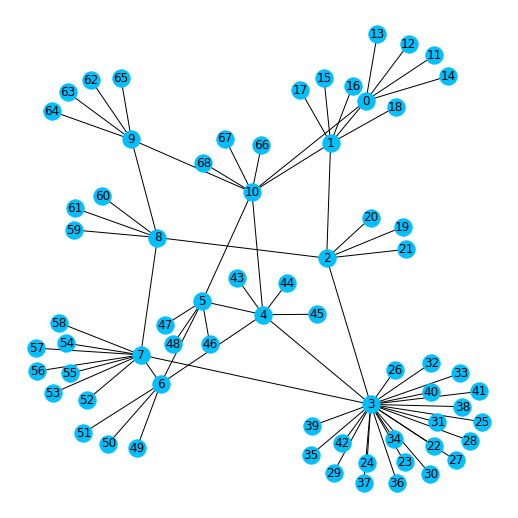

In [5]:
plt.figure(figsize = (7, 7))
nx.draw(g, with_labels = True, node_size = 300, node_color = "deepskyblue")
plt.show()

In [6]:
nx.write_gml(g, "newNodes.gml")

### Visualization by Gephi
<img src = "newNodes.png" width = 600>

### Step 3: Routing Matrix
For __each pair__ of the newly added nodes perform __shortest-path routing__ using NetworkX and __create a binary matrix $R$__ such that __each row__ of the matrix correspond to __a core node__ and __each column__ correspond to an __ordered pair of newly added nodes__. Each element of this matrix is <font style = "color: red">__one__</font> if __the shortest path between the corresponding pair <font style = "color: red">goes through</font> the corresponding core node__ and __<font style = "color: blue">zero otherwise</font>__. This matrix is sometimes called the routing matrix.


In [42]:
# new node numbers
n = len(g.node()) - 11
# row: core node, col: each pair or newly added nodes
# unordered pair (piazza instruction)
R = np.zeros((11, n * (n - 1) // 2))
print("matrix R: {}".format(R.shape))

matrix R: (11, 1653)


In [43]:
cnt = 0
for node1 in range(11, g.order() - 1):
    for node2 in range(node1 + 1, g.order()):
        pth = nx.shortest_path(g, source = node1, target = node2)
        for i in range(11):
            if i in pth:
                R[i][cnt] = 1
        cnt += 1

### Step 4: Find the solution to the following linear programming using the $cvxpy$ library:
<font style = "color: #FF9900">$$ Maximize \sum X_{i,j} $$</font><p></p>
<font style = "color: #FF9900">$$ s.t. \ \ X_{i,j} \ge 0 , RX\le B  $$</font>

where $B$ is a vector containing the __max bandwidth of each of the core nodes__. This homework assumes that all the elements of this vector are set to 10.

In [46]:
#!pip install cvxpy
from cvxpy import *

In [52]:
# B[i]: max bandwith of core node i
B = np.ones(11) * 10
x = Variable(R.shape[1])
objective = Maximize(sum(x))
# element-wise multiplication
constraints = [x >= 0, R * x <= B]
p = Problem(objective, constraints)

result = p.solve()

print("x.value:\n\t{}".format(x.value)) 
print("The optimized maximum flow is {}".format(result))

x.value:
	[1.66666667 1.66666667 1.66666667 ... 3.33333334 3.33333334 3.33333334]
The optimized maximum flow is 110.00000002324677


### Step 5: Barabasi-Albert random graph
Now create a Barabasi-Albert random graph with the same number of nodes as the previous graph and $m=1$ and visualize it using Gephi.

In [53]:
gb = nx.barabasi_albert_graph(g.order(), m = 1)

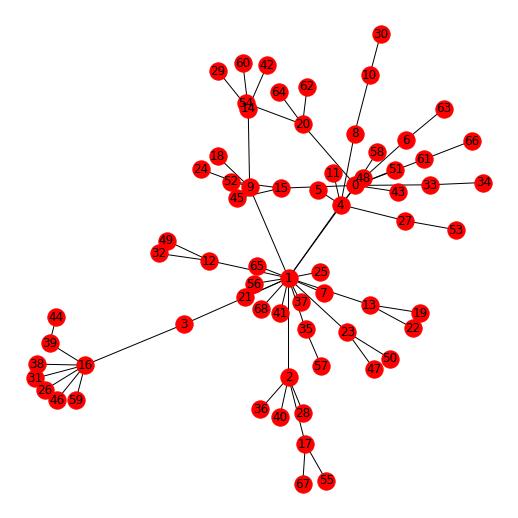

In [56]:
plt.figure(figsize = (7, 7))
nx.draw(gb, with_labels = True, node_size = 300, node_color = "red")
plt.show()

In [58]:
nx.write_gml(gb,'barabasiAlbertGraph.gml')

### Visualization of Barabasi-Albert Graph in Gephi

<img src = "bag.png" width = 600>

### Step 6: Routing matrix 

Calculate the routing matrix for this random graph with the first 11 nodes as the core. (Ignore the pairs whose shortest path does not go through the core.)

In [77]:
# precompute
pairs = []
cnt = 0
for node1 in range(11, gb.order() - 1):
    for node2 in range(node1 + 1, gb.order()):
        pth = nx.shortest_path(gb, source = node1, target = node2)
        for i in range(11):
            if i in pth:
                pairs.append(pth)
                cnt += 1
                break

#### ignore the pairs that do not go through the core nodes

In [78]:
R_ba = np.zeros((11, cnt))
for col in range(R_ba.shape[1]):
    pth = set(pairs[col])
    for i in range(11):
        if i in pth:
            R_ba[i][col] = 1

### Step 7: Solve optimization problem
Now solve the previous optimization problem for this random graph and compare the result with the previous result. __Which network has a higher performance and why?__

In [87]:
B_ba = np.ones(11) * 10
x_ba = Variable(R_ba.shape[1])
objective_ba = Maximize(sum(x_ba))
constraints_ba = [x_ba >= 0, R_ba * x_ba <= B_ba]
p_ba = Problem(objective_ba, constraints_ba)

result_ba = p_ba.solve()
print("x.value:\n{}".format(x_ba.value))
print("The optimized maximum flow is {}".format(result_ba))

x.value:
[ 3.28893827e-13  3.28893827e-13 -8.61458790e-13 ... -9.38645494e-13
  3.30748479e-13  2.03481857e-13]
The optimized maximum flow is 50.000000000448765


<div class="alert alert-block alert-info", style = "background-color: powderblue; color: black">
    <h3>Comparison of 2 graphs both following power law distribution</h3></div>

|Graph|Graph1|Graph2|
|---|---|---|
|Model|Self-created|Barabasi-Albert|
|Routing Matrix|(11,1653)|(11, 1594)|
|Optimized Max Flow|110|50|

From the comparion table above, we can observe that the optimized maximum flow of HOT network following the power law distribution is more than double of that of Barabasi-Albert random graph. As the problems aims to maximize the flow, routing as much as flow between source and target, the graph created by us is superior to the Barabasi-Albert random graph.

Based on the aforementioned analysis, __the graph created with power law distribution with a constrained optimization has the better performance__. It also incorporates real-word engineering knowledge.

***
<h2 style = "color: #FF9900">Task 2: More on the Barabasi-Albert Model</h2>

In the previous task, you evaluated the abilities of Barabasi-Albert networks to transfer data from one node to another. In this task, you will explore these networks further.

### Step 1: Barabasi-Albert Random Graphs
Using NetworkX, generate four Barabasi-Albert Random Graphs (BARGs) with n = 1000, 10000 nodes and with parameters m = 2 , 5.

In [101]:
gb1 = nx.barabasi_albert_graph(1e3, m = 2)
gb2 = nx.barabasi_albert_graph(1e4, m = 2)
gb3 = nx.barabasi_albert_graph(1e3, m = 5)
gb4 = nx.barabasi_albert_graph(1e4, m = 5)

### Step 2: Visualization
Use NetworkX to store the graphs in .gml and then visualize them using Gephi such that __each node has a size proportional to its degree and its color is also related to its degree__. Include your visualizations in this notebook. 

__Do you see an interesting property for these graphs? Explain your answer__.

In [102]:
nx.write_gml(gb1, "bag1.gml")
nx.write_gml(gb2, "bag2.gml")
nx.write_gml(gb3, "bag3.gml")
nx.write_gml(gb4, "bag4.gml")

### Graph 1: n = 1000, m = 2
<img src = "bag1.png" width = 600>

### Graph 2: n = 10000, m = 2
<img src = "bag2.png" width = 800>

### Graph 3: n = 1000, m = 5
<img src = "bag3.png" width = 600>

### Graph 4: n = 10000, m = 5
<img src = "bag4.png" width = 800>

<div class="alert alert-block alert-info", style = "background-color: powderblue; color: black">
    <h3>Interesting Properties of BA Graphs</h3></div>


From the graphs above, we can discover that __the work is approximately scale-free and certainly contain few nodes (called hubs) with unusually high degree as compared to the other nodes of the network.__

The __Barabasi–Albert model is one of several proposed models that generate scale-free networks__. It incorporates two important general concepts: __growth and preferential attachment__. Both growth and preferential attachment exist widely in real networks.

Although a few nodes carry some unusually high importance, they do not dominate the network as they are in a random graph. As it is the preferential attachment model, there may exist ancestor nodes from which the PA start with. 

***

### Step 3: 

Calculate the __diamater and the average shortest path lengths__ of these graphs. Also plot the __(local) clustering coefficient of the nodes__ of these graphs. 

In [130]:
def count(g):
    if nx.is_connected(g):
        d, aspl = nx.diameter(g), nx.average_shortest_path_length(g)
        print("Network Diameter = {}{}Average Shorteset Path = {}".format(d, "\n", aspl))
    else: 
        gSubGraph = max(nx.connected_component_subgraphs(g), key = len)
        info = nx.info(gSubGraph).split("\n")[1:]
        info = "\t".join(info)
        print("The network is not connected. \nThe largest connected commponent:\n {}\n".format(info))
    cc = nx.clustering(g)
    return cc

### Count Network Diameter, Average Shortest Path Lengths and Clustering Coefficients

In [6]:
cc_gb1 = count(gb1)

Network Diameter = 7
Average Shorteset Path = 4.061117117117117


In [8]:
cc_gb2 = count(gb2)

Network Diameter = 9
Average Shorteset Path = 5.020026122612261


In [9]:
cc_gb3 = count(gb3)

Network Diameter = 5
Average Shorteset Path = 2.9757017017017016


In [1]:
cc_gb4 = count(gb4)

Network Diameter = 6
Average Shorteset Path = 3.669994779477948


### Plot Clusterng Coefficients

In [94]:
def plotCC(r, c, cc, size, title):
    fig, axes = plt.subplots(r, c, figsize = size)
    axes = axes.flatten()
    plt.suptitle("Cluserting Coefficient", fontsize = 16, weight = "bold")
    cmap = ["ro-", "b*-", "gx-", "mo-", "c*-", "kx-"]
    
    for i, ax in enumerate(axes):
        val, hist = zip(*sorted(Counter(cc[i].values()).items(), key = lambda x: x[0]))
        ax.plot(val, hist, cmap[i])
        ax.set_title("Graph {}: {}".format(i + 1, title[i]), fontsize = 16)
        if i >= c * (r - 1):
            ax.set_xlabel("Cluserting Coefficient", fontsize = 14)
        if i % c == 0:
            ax.set_ylabel("Numeber of Nodes", fontsize = 14)
        ax.grid(True)
    plt.show()

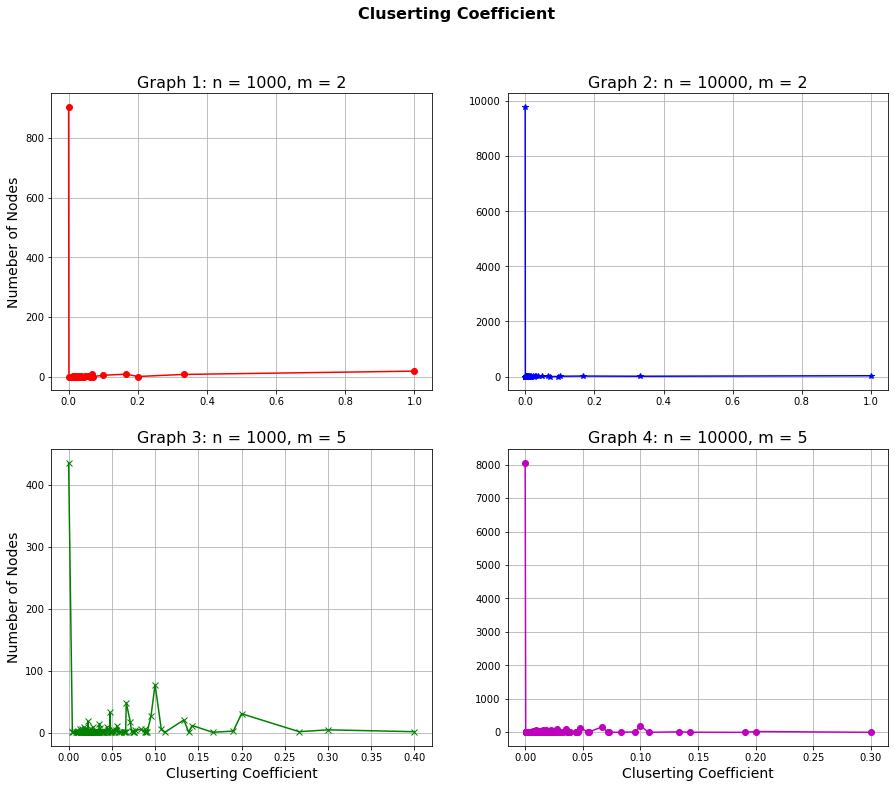

In [34]:
plotCC(2, 2,
       [cc_gb1, cc_gb2, cc_gb3, cc_gb4], 
       (15, 12),
       ["n = 1000, m = 2", "n = 10000, m = 2", "n = 1000, m = 5", "n = 10000, m = 5"])

<h2 style = "color: #FF9900">Task 3: Another Candidate Model for Describing Social Networks</h2>

As you know, __<font style = "color : #FF9900">the Watts-Strogatz generative model</font>__ was proposed in 1998 in order to address __certain limitation(s) of Erdos-Renyi random graphs__ in the context of modeling real-world social networks. In this task and the next, you will __examine the properties of Watts-Strogatz networks and compare them with those of <font style = "color : indianred">Barabasi-Albert networks</font> (one of whose objectives is to model social networks) as well as <font style = "color : deepskyblue">ER random graphs</font>__. 

### Step 1: Watts-Strogatz Random Graphs 
Using NetworkX generate three Watts-Strogatz Random Graphs (WSRGs) with __n = 1000 nodes__ and with parameters __k = 5, and p = 0.2, 0.5, and 0.8__.

In [4]:
gw1 = nx.watts_strogatz_graph(1000, k = 5, p = 0.2)
gw2 = nx.watts_strogatz_graph(1000, k = 5, p = 0.5)
gw3 = nx.watts_strogatz_graph(1000, k = 5, p = 0.8)

### Step 2: Visualization

Use NetworkX to store the graphs in .gml and then visualize them using Gephi. Include your visualizations in this notebook.

In [5]:
nx.write_gml(gw1, "wsg1.gml")
nx.write_gml(gw2, "wsg2.gml")
nx.write_gml(gw3, "wsg3.gml")

### Graph 1: n = 1000, k  = 5, p = 0.2
<img src = "gw1.png" width = 800>

### Graph 3: n = 1000, k  = 5, p = 0.5
<img src = "gw2.png" width = 800>

### Graph 3: n = 1000, k  = 5, p = 0.8
<img src = "gw3.png" width = 800>

***

### Step 3: Degree Distibution (Computation & Visualization)

Plot the degree distibution of these graphs in arithmetic and log-log scale figures. __Based on the plots, do you think Watts-Strogatz networks follow a <font style = "color: blue">power-law degree distribution</font>? Why or why not?__

In [7]:
def getDegDistribution(deg):
    val, hist = zip(*sorted(Counter(deg.values()).items(), key = lambda x: x[0]))
    return val, hist

In [28]:
def plot(gw, n, p, cmap):
    val, hist = getDegDistribution(dict(gw.degree()))
    fig, axes = plt.subplots(2, 2, figsize = (12, 12))
    ax1, ax2, ax3, ax4 = axes.flatten()
    plt.suptitle("Graph {}: n = 1000, k = 5, p = {}".format(n, p), fontsize = 16, weight = "bold")
    ax1.plot(val, hist, color = cmap[0])
    ax1.set_ylabel("Numeber of Nodes", fontsize = 14)
    ax1.set_title("Arithmetic scale", fontsize = 16)
    ax1.grid(True)
    
    ax2.loglog(val, hist, color = cmap[1])
    ax2.set_ylabel("$\log(Numeber\ of\ Nodes)$", fontsize = 14)
    ax2.set_title("log-log scale", fontsize = 16)
    ax2.grid(True)
    
    ax3.hist(dict(gw.degree()).values(), normed = True, color = cmap[0], edgecolor = "black")
    ax3.set_xlabel("Degree", fontsize = 14)
    ax3.set_ylabel("Numeber of Nodes", fontsize = 14)
    ax3.set_title("Normalized Arithmetic scale", fontsize = 16)
    #ax3.grid("-")
    
    
    ax4.hist(dict(gw.degree()).values(), normed = True, log = True, color = cmap[1], edgecolor = "black")
    ax4.set_xlabel("$\log(Degree)$", fontsize = 14)
    ax4.set_ylabel("$\log(Numeber\ of\ Nodes)$", fontsize = 14)
    ax4.set_title("Normalizedlog-log scale", fontsize = 16)
    #ax4.grid("-")
    plt.show()

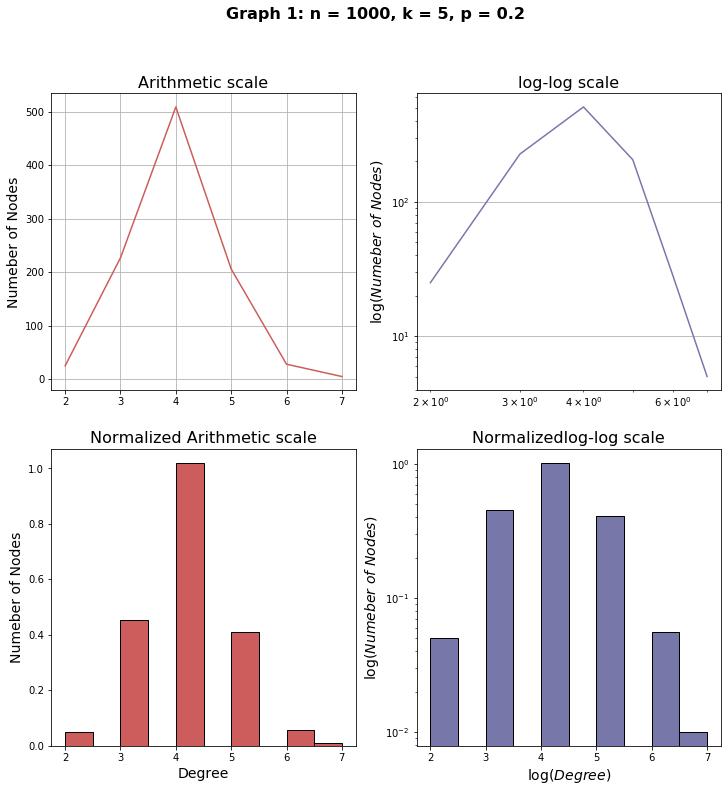

In [29]:
plot(gw1, 1, 0.2, ["indianred", "#7777aa"])

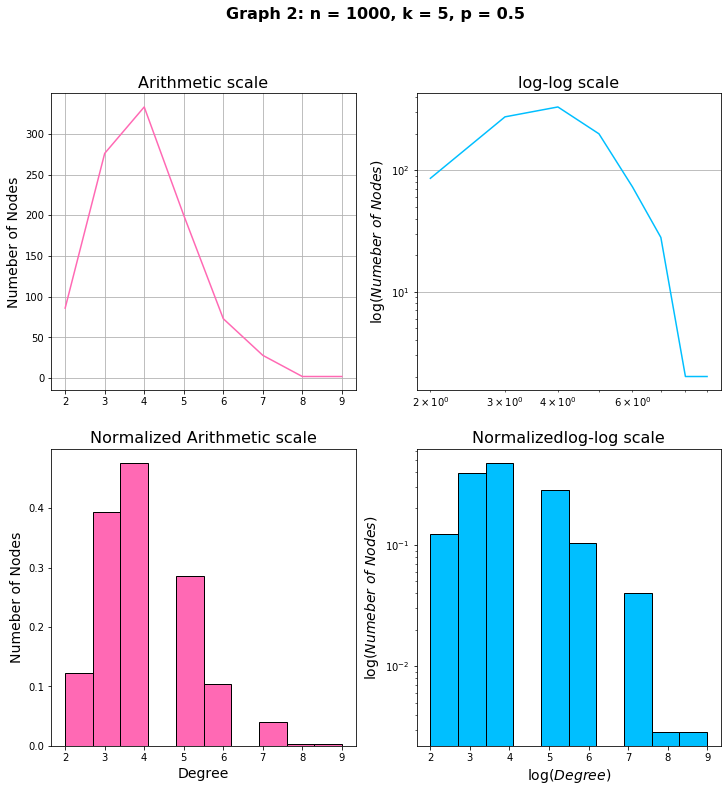

In [30]:
plot(gw2, 2, 0.5, ["hotpink", "deepskyblue"])

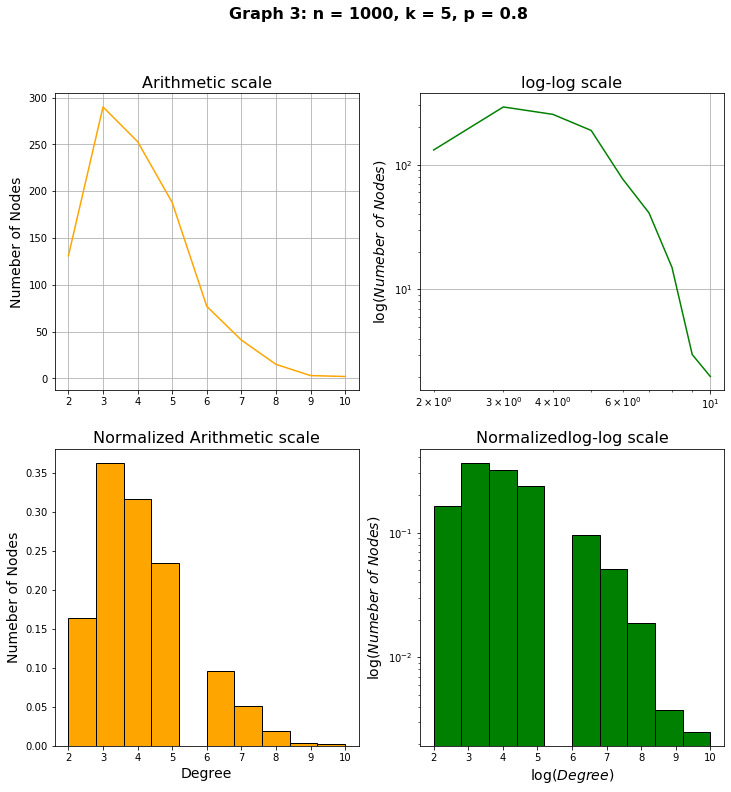

In [31]:
plot(gw3, 3, 0.8, ["orange", "green"])

<div class="alert alert-block alert-info", style = "background-color: powderblue; color: black">
    <h3>Does Watts-Strogatz follow power law distribution?</h3></div>


The Watts–Strogatz model is a random graph generation model that produces graphs with small-world properties, including short average path lengths and high clustering. Its degree distribution is a __Dirac delta function__ centered at $K$. 

__Hence, the Watts–Strogatz graphs do NOT follow a power law distribution. They do NOT exihibit power laws__.

***
### Step 4: Count diamaters, the average shortest path and clustering coefficients

Calculate the __diamaters and the average shortest path lengths__ of these graphs. Also __plot the clustering coefficients of the nodes__ of these graphs. __Compare these results with the ones you obtained for the <font style = "color: indianred">Barabasi-Albert model</font>__. 

__Based on this comparison, which of the two models is a better choice for describing online social networks in your opinion? Explain your answer__.

In [103]:
cc1 = count(gw1)

Network Diameter = 12
Average Shorteset Path = 6.919133133133133


In [104]:
cc2 = count(gw2)

Network Diameter = 9
Average Shorteset Path = 5.559379379379379


In [38]:
cc3 = count(gw3)

Network Diameter = 9
Average Shorteset Path = 5.328666666666667


***
### Step 5: Plot Clusterng Coefficients

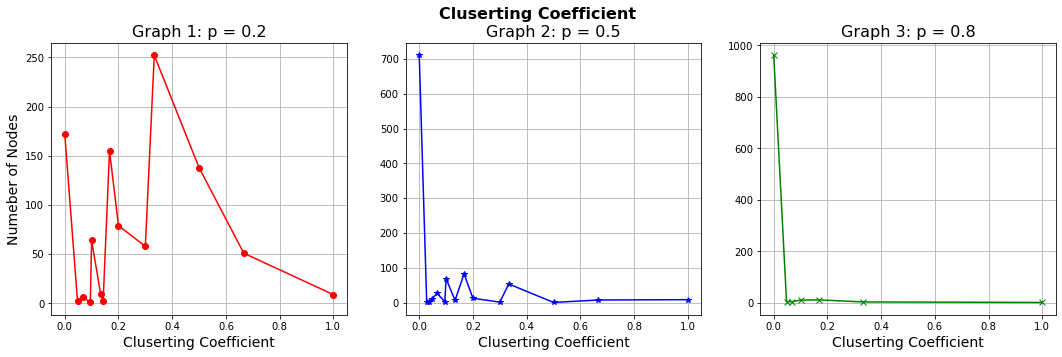

In [101]:
plotCC(1, 3, [cc1, cc2, cc3], (18, 5), ["p = {}".format(i) for i in [0.2, 0.5, 0.8]])

<div class="alert alert-block alert-info", style = "background-color: powderblue; color: black">
    <h3>Comparison of Watts-Strogatz and Barabasi-Albert Models</h3></div>


|Graph|p|k|# of nodes|Diameter|Average<br>Shortest Path|
|---|---|---|---|---|---|
|Watts-Strogatz|0.2|5|1000|12|6.9191|
|Watts-Strogatz|0.5|5|1000|9|5.5594|
|Watts-Strogatz|0.8|5|1000|9|5.3287|

|Graph|m|# of nodes|Diameter|Average<br>Shortest Path|
|---|---|---|---|---|
|Barabasi-Albert|2|1000|7|4.0611|
|Barabasi-Albert|2|10000|9|5.0200|
|Barabasi-Albert|5|1000|5|2.9757|
|Barabasi-Albert|5|10000|6|3.6700|

### Analysis
The __Watts and Strogatz model__ was designed as the simplest possible model that __addresses the limitation of ER model, which is lack of local clustering and triadic closures. It accounts for clustering while retaining the short average path lengths of the ER model__. It does so by interpolating between a randomized structure close to ER graphs and a regular ring lattice. Consequently, the model is able to at least __partially explain the "small-world" phenomena in a variety of networks__, such as the power grid, neural network of C. elegans, networks of movie actors, or fat-metabolism communication in budding yeast.

The __Barabasi–Albert model__ is an algorithm for generating random __scale-free networks__ using a preferential attachment mechanism. Several natural and human-made systems, including the Internet, the world wide web, citation networks, and __some social networks are thought to be approximately scale-free and certainly contain few nodes (called hubs) with unusually high degree as compared to the other nodes of the network__. The BA model tries to explain the existence of such nodes in real networks. 

### Conclusion
Hence, the __Barabasi–Albert model is a better choice for the online social network__. Its great examples are internet topologies, the Web, social networks and neural networks! 

***

### Step 6: Network: hierarchical structure

Now, consider a network that describes the __hierarchical structure of an organization__, i.e., a network that captures the hierarchical connections between the employees of the organization. It is a network in which __two employees are connected by an edge if and only if one of them is the immediate supervisor/boss of the other__. 

__Do you think either of the two models that you have examined so far is suitable for describing such a hierarchical network? Why or why not?__ You may assume that __if an employee has two or more immediate supervisors, then all of these supervisors are located at the same level in the hierarchy of the organization__.

<div class="alert alert-block alert-info", style = "background-color: powderblue; color: black">
    <h3>Can Watts-Strogatz and Barabasi-Albert Models represent hierarchical structure ?</h3></div>
    
__The hierarchical network model is part of the scale-free model family sharing their main property of having proportionally more hubs among the nodes than by random generation__.

However, it significantly __differs from the other similar models (Barabási–Albert, Watts–Strogatz)__ in the distribution of the __nodes' clustering coefficients__: as other models would predict a __constant clustering coefficient__ as the __function of the degree of the node__, in hierarchical models __nodes with more links__ are expected to have __a lower clustering coefficient__. 

Moreover, while the Barabási-Albert model predicts a decreasing average clustering coefficient as the number of nodes increases, __in the case of the hierarchical models there is no relationship between the size of the network and its average clustering coefficient__.

__Hence, neither of the two models is suitable for describing such a hierarchical network. The hierarchical network is distinct from these two models (BA and WS)__.

***

<h2 style = "color: #FF9900">Task 4 (Bonus Task): Do the above models outperform ER Random Graphs?</h2>

### Step 1: 

Using NetworkX, generate __six Erdos-Renyi Random Graphs (ERRGs) with n = 1000 nodes and with parameters $p = 0.5/n, 1/n,\ 1.5/n,\ 0.5\ln(n)/n,\ \ln(n)/n,\ 1.5\ln(n)/n$__.

In [79]:
n = 1000
P = [0.5 / n, 1 / n, 1.5 / n, 0.5 * log(n) / n, log(n) / n, 1.5 * log(n) / n]
ER = {}
for p in P:
    gE = nx.erdos_renyi_graph(n, p, seed = 256, directed = False)
    info = nx.info(gE)
    info = info.replace("\n", "\t")
    print("p = {:.4f}\n\t{}\n".format(p, info))
    ER[p] = gE

p = 0.0005
	Name: 	Type: Graph	Number of nodes: 1000	Number of edges: 251	Average degree:   0.5020

p = 0.0010
	Name: 	Type: Graph	Number of nodes: 1000	Number of edges: 466	Average degree:   0.9320

p = 0.0015
	Name: 	Type: Graph	Number of nodes: 1000	Number of edges: 715	Average degree:   1.4300

p = 0.0035
	Name: 	Type: Graph	Number of nodes: 1000	Number of edges: 1670	Average degree:   3.3400

p = 0.0069
	Name: 	Type: Graph	Number of nodes: 1000	Number of edges: 3451	Average degree:   6.9020

p = 0.0104
	Name: 	Type: Graph	Number of nodes: 1000	Number of edges: 5171	Average degree:  10.3420



### Step 2: Diamaters, average shortest path lengths and clustering coefficients

Calculate the diamaters and the average shortest path lengths of these graphs. Also plot the clustering coefficients of the nodes of these graphs. 

__Compare these results with the ones you obtained for the previous models__. Based on your comparison, __do you think that the Barabasi-Albert and the Watts-Strogatz models are better choices than the Erdos-Renyi Model for describing online social networks? Explain your answer.__

In [131]:
CC = []
titles = ["0.5/n", "1/n", "1.5/n", "0.5ln(n)/n", "ln(n)/n", "1.5ln(n)/n"]
for i, p in enumerate(P):
    print("p = {}".format(titles[i]))
    CC.append(count(ER[p]))

p = 0.5/n
The network is not connected. 
The largest connected commponent:
 Type: Graph	Number of nodes: 11	Number of edges: 10	Average degree:   1.8182

p = 1/n
The network is not connected. 
The largest connected commponent:
 Type: Graph	Number of nodes: 89	Number of edges: 88	Average degree:   1.9775

p = 1.5/n
The network is not connected. 
The largest connected commponent:
 Type: Graph	Number of nodes: 551	Number of edges: 582	Average degree:   2.1125

p = 0.5ln(n)/n
The network is not connected. 
The largest connected commponent:
 Type: Graph	Number of nodes: 961	Number of edges: 1669	Average degree:   3.4735

p = ln(n)/n
Network Diameter = 7
Average Shorteset Path = 3.7873413413413415
p = 1.5ln(n)/n
Network Diameter = 5
Average Shorteset Path = 3.2134474474474475


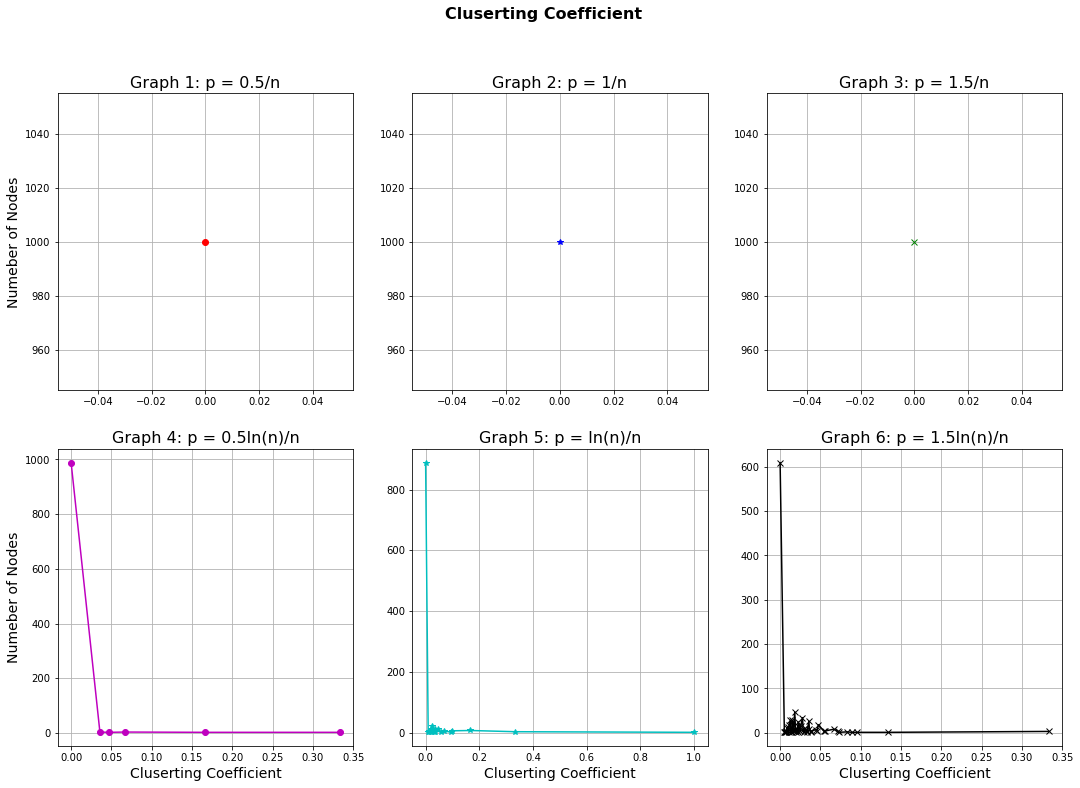

In [99]:
plotCC(2, 3, [CC[p] for p in P], (18, 12), ["p = {}".format(t) for t in titles])

<div class="alert alert-block alert-info", style = "background-color: powderblue; color: black">
    <h3>Which model is better for describing online social network?</h3></div>
    
__The Barabasi-Albert and the Watts-Strogatz models are better choices than the Erdos-Renyi Model for describing online social networks.__ Erdos Renyi networks do not generate local clustering and triadic closures. Instead, because they have a constant, random, and independent probability of two nodes being connected, __ER graphs have a low clustering coefficient, which is not align with the online social networks__

Many observed __social networks__ (at least approximately) fall into the class of __scale-free networks__, meaning that they have __power-law (or scale-free) degree distributions__, while __random graph models such as the Erdős–Rényi (ER) model and the Watts–Strogatz (WS) model do not exhibit power laws__.